# Vector Quantized Auto-Encoder

In [350]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import data_loader

batch_size = 128
lr = .001

dim_input = (3, 32, 32)
dim_hidden = 400
dim_latent = 200
beta_commitment = 0.25

train_loader, validation_loader, test_loader = data_loader.load_cifar10(batch_size=batch_size)

torch.cuda.is_available()

Files already downloaded and verified


True

torch.Size([3, 32, 32])


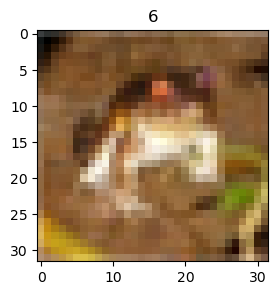

In [351]:
import matplotlib.pyplot as plt

print(train_loader.dataset[4][0].shape)

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0].permute(1, 2, 0))
plt.show()

In [352]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super(VectorQuantizer, self).__init__()
    
    self.embedding = nn.Embedding(num_embeddings, embedding_dim) # (K,D)
    # initialize weights of imbedding from uniform distribution
    self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    self.commitment_cost = commitment_cost
    
  def forward(self, inputs):
    inputs = inputs.permute(0,2,3,1).contiguous() # (B, H, W, C=D)
    K, D = self.embedding.weight.data.shape
    input_shape = inputs.shape
    
    flat_input = inputs.view(-1, D) # (B*H*W, C=D)
    
    # distance between choice of embeddings and input
    # distances = (torch.sum(flat_input**2, dim=1, keepdim=True) # (B*H*W, 1)
    #              + torch.sum(self.embedding.weight**2, dim=1) # (B*H*W, 1)
    #              - 2 *torch.matmul(flat_input, self.embedding.weight.t())) # (B*H*W, D) x (D x K) = (B*H*W, K)
    # # (B*H*W, K)
    distances = (-torch.cdist(flat_input, self.embedding.weight, p=2)) ** 2
    
    # set the encoding
    # encoding to index of closest embeddings to input
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # (B*H*W, 1), indicies will be in the range of K
    encodings = torch.zeros(encoding_indices.shape[0], K) # (B*H*W,s K)
    encodings = encodings.scatter(1, encoding_indices, 1) # set encoding indices as 1
    
    quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape) # (B*H*W, K) x (K, D) = (B*H*W, D) => (B, H, W, D)
    
    # q_latent_loss + beta * e_latent_loss
    e_latent_loss = functional.mse_loss(quantized.detach(), inputs) # move inputs closer to embeddings
    q_latent_loss = functional.mse_loss(quantized, inputs.detach()) # move embeddings closer to inputs
    loss = q_latent_loss + self.commitment_cost * e_latent_loss
    
    # what is the point of detaching the second term? why not just load the resultant quantized values calculated above?
    quantized = inputs + (quantized - inputs).detach() # (B, H, W, D)
    avg_probs = torch.mean(encodings, dim=0) # (K)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10))) # just something to mesure performance
    
    return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [353]:
class Residual(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
    super(Residual, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,
              out_channels=num_residual_hiddens,
              kernel_size=3, stride=1, padding=1, bias=False)
    self.conv2 = nn.Conv2d(in_channels=num_residual_hiddens,
              out_channels=num_hiddens,
              kernel_size=1, stride=1, bias=False)

  def forward(self, x):# -> Any:
    h1 = self.conv1(x)
    h1 = functional.relu(h1)
    h2 = self.conv2(h1)
    h2 = functional.relu(h2)
    return h2 + x

In [354]:
class Encoder(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=num_hiddens//2, out_channels=num_hiddens, kernel_size=4, stride=2, padding=1)
    self.residual1 = Residual(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
    self.residual2 = Residual(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
    
  def forward(self, inputs):
    h = self.conv1(inputs)
    h = functional.relu(h)
    h = self.conv2(h)
    h = functional.relu(h)
    h = self.residual1(h)
    h = self.residual2(h)
    return h

In [355]:
class Decoder(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
    super(Decoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1)
    self.residual1 = Residual(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
    self.residual2 = Residual(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
    self.convT1 = nn.ConvTranspose2d(in_channels=num_hiddens, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1)
    self.convT2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, out_channels=3, kernel_size=4, stride=2, padding=1)
  
  def forward(self, inputs):
    h = self.residual1(inputs)
    h = self.residual2(h)
    h = self.convT1(h)
    h = functional.relu(h)
    h = self.convT2(h)
    h = functional.relu(h)
    return h

In [356]:
class VQVAE(nn.Module):
  def __init__(self, num_hiddens, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost):
    super(VQVAE, self).__init__()
    self.encoder = Encoder(in_channels=3, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
    self.vq_vae = VectorQuantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim, commitment_cost=commitment_cost)
    self.decoder = Decoder(in_channels=embedding_dim, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
    
  def forward(self, x):
    z = self.encoder(x)
    loss, quantized, perplexity, _ = self.vq_vae(z)
    x_hat = self.decoder(quantized)
    
    return loss, x_hat, perplexity

In [357]:
torch.autograd.set_detect_anomaly(True)

model = VQVAE(num_hiddens=128, num_residual_hiddens=32, num_embeddings=512, embedding_dim=64, commitment_cost=0.25)
optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=False)

epochs = 10

mse_loss = nn.MSELoss()

model.train()
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    for i, (X, y) in enumerate(train_loader):
        model.train()
        vq_loss, x_hat, perplexity = model(X)
        recon_error = mse_loss(x_hat, X)
        loss = recon_error + vq_loss
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % 100 == 0:
            model.eval()
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print('---------------------------')

epoch 0


100 iterations
recon_error: 0.092
perplexity: 4.758
---------------------------
200 iterations
recon_error: 0.021
perplexity: 19.867
---------------------------
300 iterations
recon_error: 0.014
perplexity: 43.071
---------------------------
epoch 1
100 iterations
recon_error: 0.010
perplexity: 94.592
---------------------------
200 iterations
recon_error: 0.009
perplexity: 114.999
---------------------------
300 iterations
recon_error: 0.008
perplexity: 123.366
---------------------------
epoch 2
100 iterations
recon_error: 0.007
perplexity: 144.139
---------------------------
200 iterations
recon_error: 0.006
perplexity: 148.659
---------------------------
300 iterations
recon_error: 0.006
perplexity: 155.014
---------------------------
epoch 3
100 iterations
recon_error: 0.005
perplexity: 163.553
---------------------------
200 iterations
recon_error: 0.005
perplexity: 167.241
---------------------------
300 iterations
recon_error: 0.005
perplexity: 169.254
-------------------------

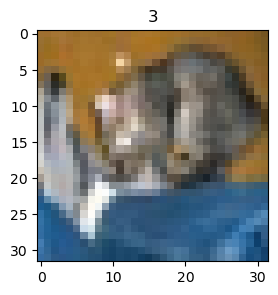

In [385]:
plt.figure(figsize=(3, 3))
plt.title(f"{test_loader.dataset[0][1]}")
plt.imshow(test_loader.dataset[0][0].permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


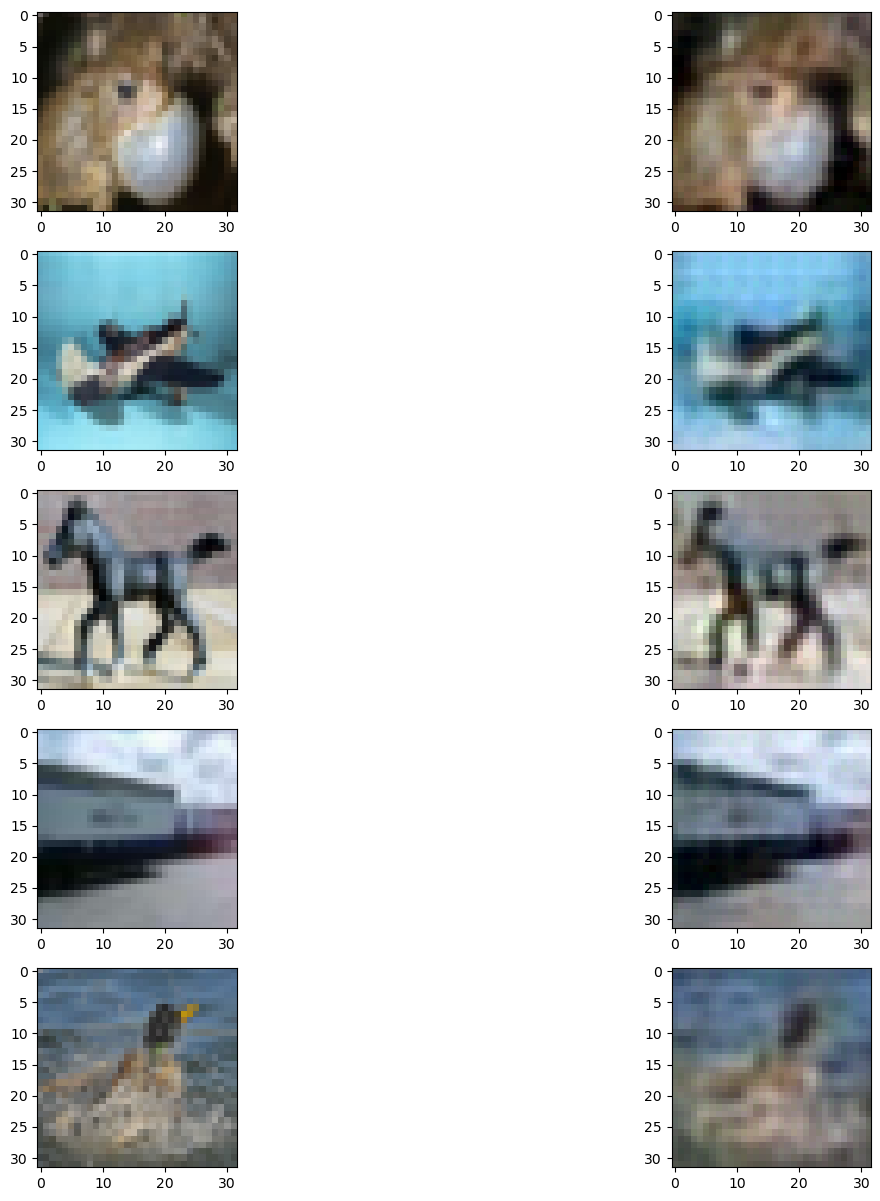

In [405]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        if j < 5:
            _, x_hat, _ = model(test_X)
            ax[j, 0].imshow(test_X[0].permute(1, 2, 0))
            ax[j, 1].imshow(x_hat[0].permute(1, 2, 0))
        else:
            break
plt.show()